In [1]:
!pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer


In [2]:
!pip install triton


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.5 MB/s eta 0:00:00


In [3]:
import re
import numpy as np
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Load and process the Paul Graham essays text
with open('/content/holmes.txt', 'r') as file:
    text = file.read().lower()

# Remove special characters except for full stops

# Preprocess text
text = re.sub(r'http\S+', '', text)  # Remove URLs
text = re.sub(r'(\w)(\.)', r'\1 .', text)  # Separate periods attached to words or numbers
text = re.sub(r'[^a-zA-Z0-9 .]', ' ', text).lower()  # Keep only alphanumeric characters and periods
text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

# Tokenize the processed text
tokenizer = Tokenizer(filters='')  # Ensures no default filtering
tokenizer.fit_on_texts([text])

# Manually add period (.) if not present
if '.' not in tokenizer.word_index:
    tokenizer.word_index['.'] = len(tokenizer.word_index) + 1
stoi = tokenizer.word_index  # Word to index mapping
itos = {i: w for w, i in stoi.items()}  # Index to word mapping

# Tokenize text into words
words = text.split()

# Parameters
block_size = 5
X, Y = [], []

# Initialize context with full stops ('.')
context = [stoi.get('.', None)] * block_size

# Generate training pairs with the updated context
for i, word in enumerate(words):
    target = stoi.get(word, None)

    # Skip iteration if context or target has None
    if target is None or None in context:
        print(f"Skipping: Word '{word}' or context contains None.")
        continue

    X.append(list(context))  # Append a copy of the current context
    Y.append(target)

    # Print the first 20 context-target pairs for verification
    if i < 50:
        print(' '.join(itos[idx] for idx in context if idx is not None), '--->', itos.get(target, '?'))

    # Update context by shifting left and adding the current target
    context = context[1:] + [target]

# Convert to tensors for model input
import torch
X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

. . . . . ---> project
. . . . project ---> gutenberg
. . . project gutenberg ---> s
. . project gutenberg s ---> the
. project gutenberg s the ---> adventures
project gutenberg s the adventures ---> of
gutenberg s the adventures of ---> sherlock
s the adventures of sherlock ---> holmes
the adventures of sherlock holmes ---> by
adventures of sherlock holmes by ---> arthur
of sherlock holmes by arthur ---> conan
sherlock holmes by arthur conan ---> doyle
holmes by arthur conan doyle ---> this
by arthur conan doyle this ---> ebook
arthur conan doyle this ebook ---> is
conan doyle this ebook is ---> for
doyle this ebook is for ---> the
this ebook is for the ---> use
ebook is for the use ---> of
is for the use of ---> anyone
for the use of anyone ---> anywhere
the use of anyone anywhere ---> at
use of anyone anywhere at ---> no
of anyone anywhere at no ---> cost
anyone anywhere at no cost ---> and
anywhere at no cost and ---> with
at no cost and with ---> almost
no cost and with almost ---

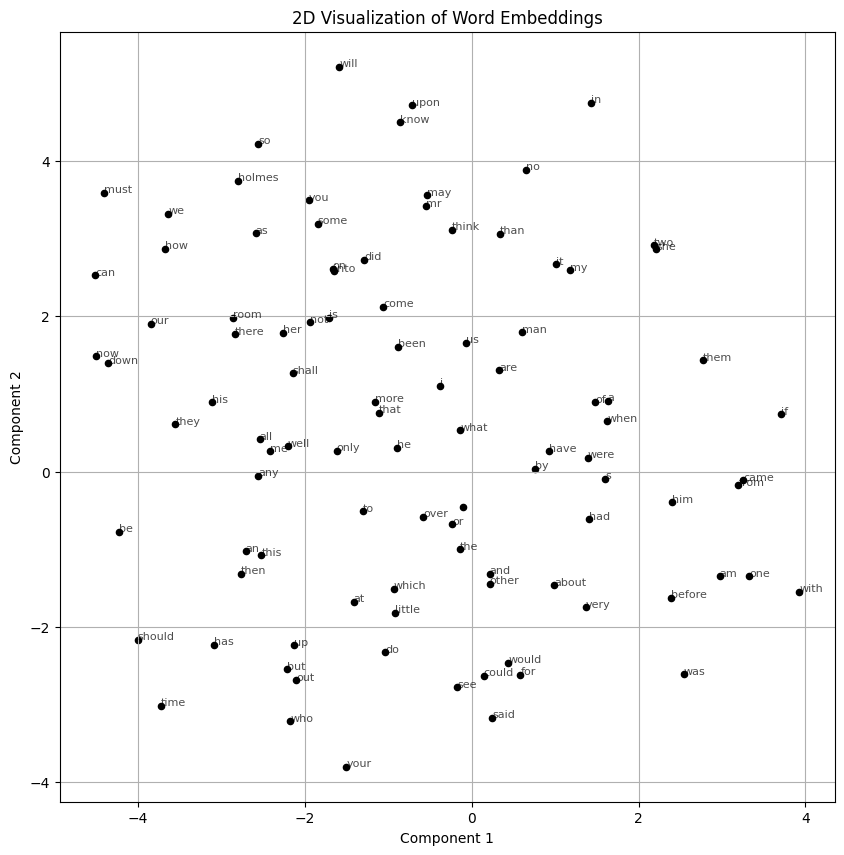

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define larger embedding size for words
embedding_dim = 32
hidden_size = 1024
# Assuming you have a tokenizer or a vocabulary list
vocab_size = len(tokenizer.word_index) + 1  # +1 if padding index is used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model and tensors to the device
embedding_layer = nn.Embedding(vocab_size, embedding_dim).to(device)

class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size=1024):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)  # Flatten the embedding output
        x = torch.sin(self.lin1(x))  # Apply activation
        x = self.lin2(x)  # Output logits for vocabulary size
        return x


# Function to plot word embeddings
def plot_word_embeddings(model, tokenizer, num_words_to_visualize=100, perplexity=30.0):
    # Extract the embedding layer weights
    embeddings = model.emb.weight.detach().cpu().numpy()

    # Choose the indices of words to visualize
    word_indices = np.arange(1, min(vocab_size, num_words_to_visualize))
    selected_embeddings = embeddings[word_indices]

    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embeddings_2d = tsne.fit_transform(selected_embeddings)

    # Plot the embeddings
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='k', s=20)  # Points color and size

    # Annotate the points with corresponding words
    for i, index in enumerate(word_indices):
        plt.annotate(tokenizer.index_word.get(index, '?'), (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

    plt.title("2D Visualization of Word Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# Example model usage
model = NextWord(block_size, vocab_size, embedding_dim).to(device)
#model = torch.compile(model)

# Pseudo-code for preparing your data loader and criterion
# data_loader = ...
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model (implement the data loading part)
# train_model(model, data_loader, criterion, optimizer, num_epochs=10)

# Visualize the word embeddings after training
plot_word_embeddings(model, tokenizer)


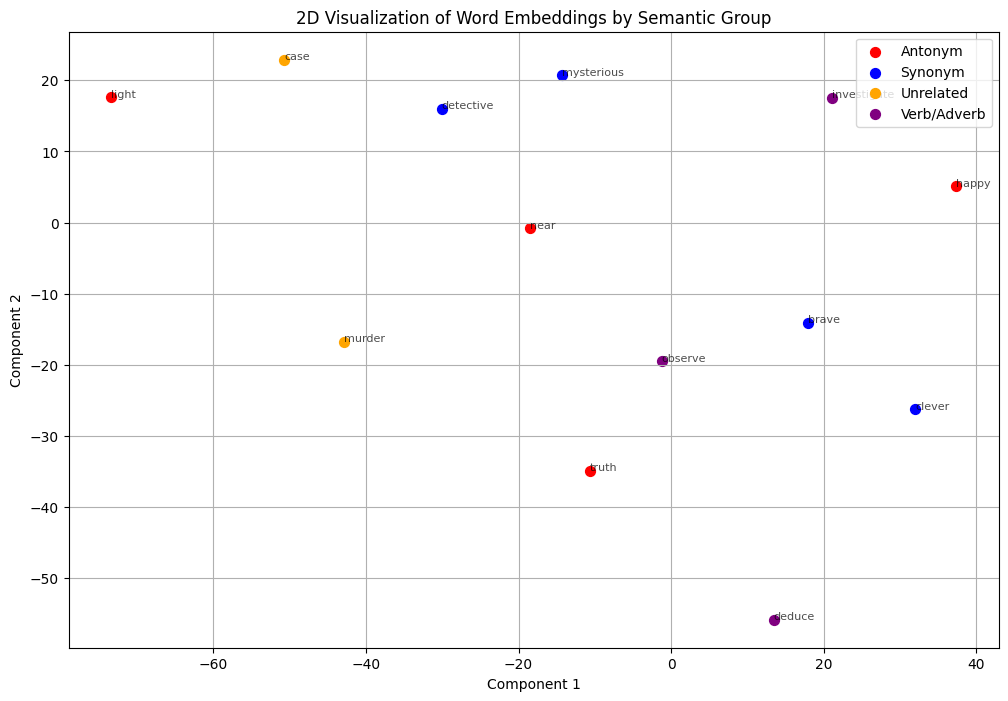

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Function to get indices for words in each category
def get_word_indices(word_list, tokenizer):
    return [tokenizer.word_index[word] for word in word_list if word in tokenizer.word_index]

# Define word groups (examples)
synonyms = ["clever", "detective", "mysterious", "brave"]
antonyms = ["happy", "truth", "light", "near"]
names_pronouns = ["Sherlock", "Watson", "I", "Mrs. Hudson"]
verbs_adverbs = ["investigate", "observe", "deduce", "conclude"]
unrelated = ["London", "Baker Street", "murder", "case"]

# Retrieve indices for each group
synonym_indices = get_word_indices(synonyms, tokenizer)
antonym_indices = get_word_indices(antonyms, tokenizer)
names_pronouns_indices = get_word_indices(names_pronouns, tokenizer)
verbs_adverbs_indices = get_word_indices(verbs_adverbs, tokenizer)
unrelated_indices = get_word_indices(unrelated, tokenizer)

# Collect indices and labels
all_indices = synonym_indices + antonym_indices + names_pronouns_indices + verbs_adverbs_indices + unrelated_indices
all_labels = (["Synonym"] * len(synonym_indices) +
              ["Antonym"] * len(antonym_indices) +
              ["Name/Pronoun"] * len(names_pronouns_indices) +
              ["Verb/Adverb"] * len(verbs_adverbs_indices) +
              ["Unrelated"] * len(unrelated_indices))

# Extract embeddings for selected words
embeddings = model.emb.weight.detach().cpu().numpy()
selected_embeddings = embeddings[all_indices]

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, perplexity=5.0, random_state=42)
embeddings_2d = tsne.fit_transform(selected_embeddings)

# Plot embeddings with different colors for each category
plt.figure(figsize=(12, 8))
colors = {'Synonym': 'blue', 'Antonym': 'red', 'Name/Pronoun': 'green', 'Verb/Adverb': 'purple', 'Unrelated': 'orange'}

for label in np.unique(all_labels):
    indices = [i for i, l in enumerate(all_labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label, color=colors[label], s=50)

# Add labels for the words
for i, index in enumerate(all_indices):
    word = tokenizer.index_word.get(index, "?")
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

plt.title("2D Visualization of Word Embeddings by Semantic Group")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def generate_sentence(model, tokenizer, block_size, max_len=10):
    # Initialize context with zeros, representing the start token (you may replace it with the actual start token index if needed)
    context = [0] * block_size  # Adjust this if you have a specific start token
    sentence = ''

    for i in range(max_len):
        # Prepare the input tensor from the context
        x = torch.tensor(context).view(1, -1).to(device)  # Ensure input tensor is on the same device as the model

        # Forward pass to get predictions
        with torch.no_grad():  # Disable gradient calculation for inference
            y_pred = model(x)  # Get predictions from the model

        # Sample from the distribution
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()  # Sample from distribution

        # Convert index to word using the tokenizer
        word = tokenizer.index_word.get(ix, '?')  # Get word or default to '?'

        # Check for end token to stop generation
        if word == '<end>':  # Replace with your actual end token if needed
            break

        sentence += (word + ' ')  # Append the word to the sentence

        # Update context for the next word
        context = context[1:] + [ix]  # Update context with the new index

    return sentence.strip()  # Return the generated sentence


In [8]:
# Example of generating multiple sentences
for i in range(10):
    generated_sentence = generate_sentence(model, tokenizer, block_size, max_len=10)
    print(f"Generated Sentence {i + 1}: {generated_sentence}")


Generated Sentence 1: unbreakable ryder sunbeam purchasing slippery oscillation 2001 untimely offhand promptly
Generated Sentence 2: softer cobbler wander sketched earned injections shortcomings moonlight thickly swollen
Generated Sentence 3: horrible flush marrying escape gregory caps round capable define weekly
Generated Sentence 4: luxuriant sweating gloom market deference warmest blowing risers reasoning ways
Generated Sentence 5: accurately started breast becoming main rattle status written twitching closed
Generated Sentence 6: lane ease symptom steely they shone warren spreading housekeeper 18
Generated Sentence 7: struck retain codes agra indignation proof curious doubtless assisting bunch
Generated Sentence 8: tuesday online obvious reasons snatched invested fees struck deceased .8
Generated Sentence 9: too moss coloured hampshire direction rising eton succinct tack wherever
Generated Sentence 10: liberated professor flaring ears wigmore candid pushed silk memoir gripping


In [9]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

emb.weight torch.Size([8184, 32])
lin1.weight torch.Size([1024, 160])
lin1.bias torch.Size([1024])
lin2.weight torch.Size([8184, 1024])
lin2.bias torch.Size([8184])


In [10]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Training loop
batch_size = 4096
print_every = 100
elapsed_time = []


for epoch in range(600):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        x = x.to(device)  # Ensure input tensor is on the same device as the model
        y = y.to(device)  # Ensure target tensor is also on the same device
        # Forward pass
        y_pred = model(x)

        # Compute loss
        loss = loss_fn(y_pred, y)

        # Backward pass and optimization
        loss.backward()
        opt.step()
        opt.zero_grad()

    end_time = time.time()
    elapsed_time.append(end_time - start_time)

    # Print progress at intervals
    if epoch % print_every == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Time: {elapsed_time[-1]:.2f} sec")

Epoch 0, Loss: 8.9304, Time: 2.01 sec
Epoch 100, Loss: 0.4076, Time: 1.64 sec
Epoch 200, Loss: 0.3194, Time: 1.62 sec
Epoch 300, Loss: 0.2302, Time: 1.63 sec
Epoch 400, Loss: 0.3525, Time: 1.62 sec
Epoch 500, Loss: 0.3932, Time: 1.62 sec


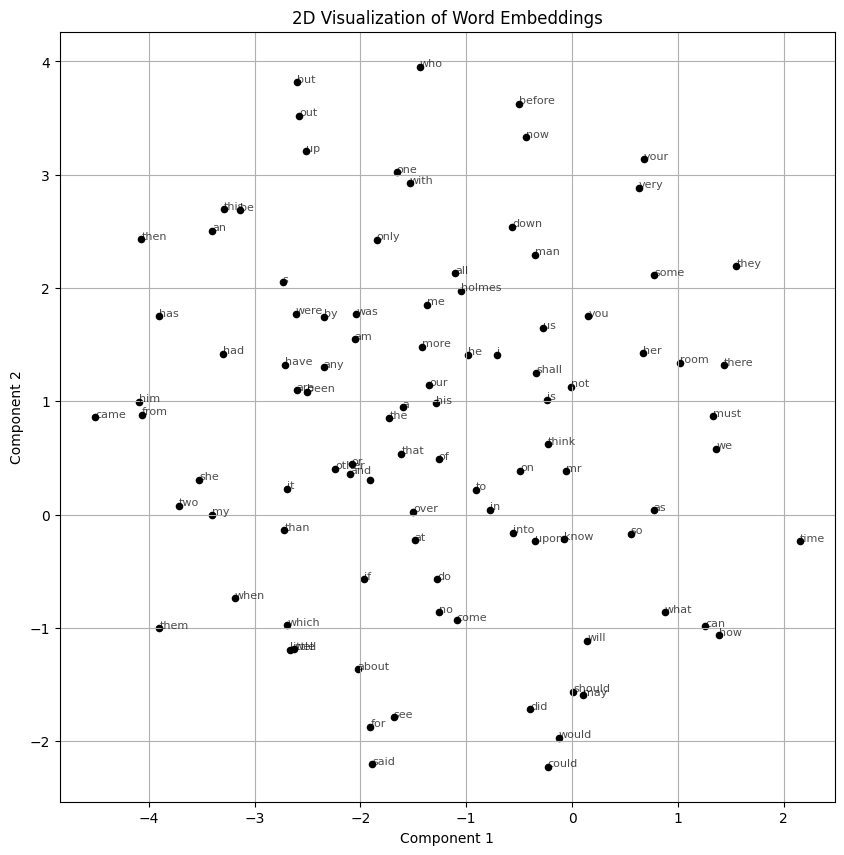

In [11]:
# Visualize the embedding

plot_word_embeddings(model, tokenizer)

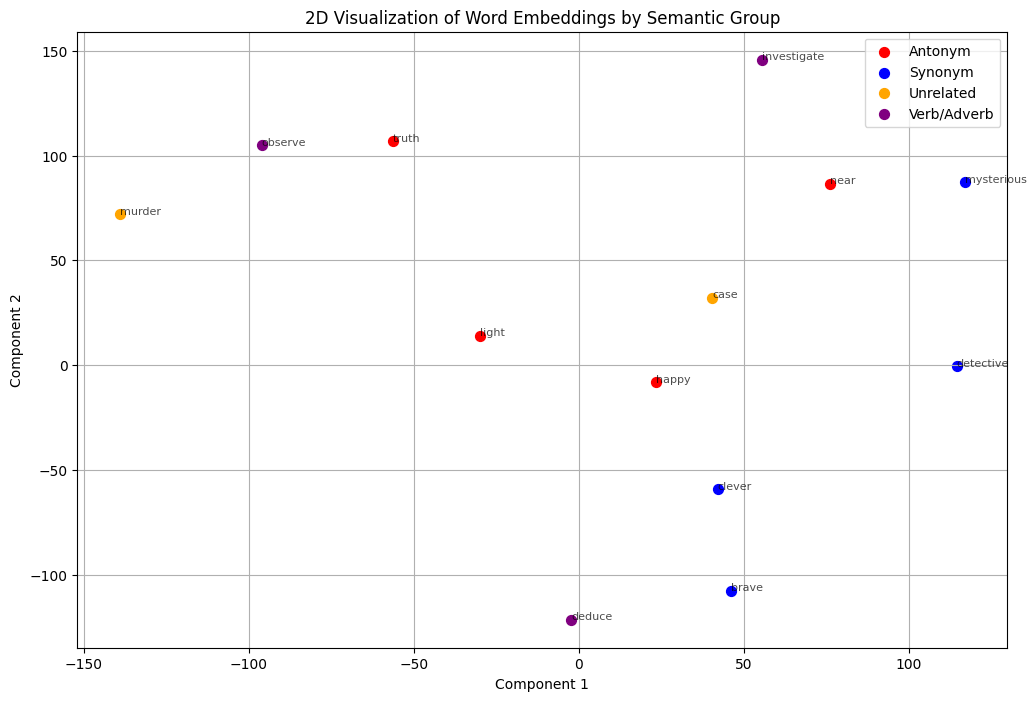

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Function to get indices for words in each category
def get_word_indices(word_list, tokenizer):
    return [tokenizer.word_index[word] for word in word_list if word in tokenizer.word_index]

# Define word groups (examples)
synonyms = ["clever", "detective", "mysterious", "brave"]
antonyms = ["happy", "truth", "light", "near"]
names_pronouns = ["Sherlock", "Watson", "I", "Mrs. Hudson"]
verbs_adverbs = ["investigate", "observe", "deduce", "conclude"]
unrelated = ["London", "Baker Street", "murder", "case"]

# Retrieve indices for each group
synonym_indices = get_word_indices(synonyms, tokenizer)
antonym_indices = get_word_indices(antonyms, tokenizer)
names_pronouns_indices = get_word_indices(names_pronouns, tokenizer)
verbs_adverbs_indices = get_word_indices(verbs_adverbs, tokenizer)
unrelated_indices = get_word_indices(unrelated, tokenizer)

# Collect indices and labels
all_indices = synonym_indices + antonym_indices + names_pronouns_indices + verbs_adverbs_indices + unrelated_indices
all_labels = (["Synonym"] * len(synonym_indices) +
              ["Antonym"] * len(antonym_indices) +
              ["Name/Pronoun"] * len(names_pronouns_indices) +
              ["Verb/Adverb"] * len(verbs_adverbs_indices) +
              ["Unrelated"] * len(unrelated_indices))

# Extract embeddings for selected words
embeddings = model.emb.weight.detach().cpu().numpy()
selected_embeddings = embeddings[all_indices]

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, perplexity=5.0, random_state=42)
embeddings_2d = tsne.fit_transform(selected_embeddings)

# Plot embeddings with different colors for each category
plt.figure(figsize=(12, 8))
colors = {'Synonym': 'blue', 'Antonym': 'red', 'Name/Pronoun': 'green', 'Verb/Adverb': 'purple', 'Unrelated': 'orange'}

for label in np.unique(all_labels):
    indices = [i for i, l in enumerate(all_labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label, color=colors[label], s=50)

# Add labels for the words
for i, index in enumerate(all_indices):
    word = tokenizer.index_word.get(index, "?")
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

plt.title("2D Visualization of Word Embeddings by Semantic Group")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Example of generating multiple sentences
for i in range(10):
    generated_sentence = generate_sentence(model, tokenizer, block_size, max_len=10)
    print(f"Generated Sentence {i + 1}: {generated_sentence}")


Generated Sentence 1: the first or is a good wheeler of events at
Generated Sentence 2: the first or is a good wheeler of events at
Generated Sentence 3: the first or is a good wheeler and the house
Generated Sentence 4: the side of the bed and you in that chair
Generated Sentence 5: the first or the door the work and you to
Generated Sentence 6: the first or is a good wheeler and the house
Generated Sentence 7: the first or yes . it was the bisulphate of
Generated Sentence 8: the first or yes sir . where rather a better
Generated Sentence 9: the first or is a good wheeler and the house
Generated Sentence 10: the first or yes . it was the bisulphate of


In [15]:
import os

# Define directory to save models
model_dir = "/content/saved_models"
os.makedirs(model_dir, exist_ok=True)

# Save model with unique configurations
def save_model_variant(model, variant_name):
    torch.save(model.state_dict(), os.path.join(model_dir, f"{variant_name}.pt"))

# Example of saving model variants
save_model_variant(model, "embedding32_hidden1024_holmes")

In [16]:
# Define the NextWord model and save it to model.py

code = """
# model.py
# model.py
import torch
import torch.nn as nn

class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size=1024):
        super(NextWord, self).__init__()
        self.block_size = block_size
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)  # Flatten the embedding output
        x = torch.sin(self.lin1(x))  # Apply activation
        x = self.lin2(x)  # Output logits for vocabulary size
        return x



"""

# Save code to model.py
with open("/content/model.py", "w") as file:
    file.write(code)

print("model.py created successfully!")

model.py created successfully!


In [17]:
# Define functions to save and load tokenizer, then save it to tokenizer.py

code = """
import pickle

def save_tokenizer(tokenizer, path='/content/tokenizer_32_holmes.pkl'):
    # Save the tokenizer to a file
    with open(path, 'wb') as f:
        pickle.dump(tokenizer, f)

def load_tokenizer(path='/content/tokenizer_32_holmes.pkl'):
    # Load the tokenizer from a file
    with open(path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer
"""

# Save code to tokenizer.py
with open("/content/tokenizer_32_holmes.py", "w") as file:
    file.write(code)

print("tokenizer_32_holmes.py created successfully!")

tokenizer_32_holmes.py created successfully!


In [18]:
from tokenizer_32_holmes import save_tokenizer
save_tokenizer(tokenizer)

In [19]:
# # Streamlit app code with word prediction count selection

# import streamlit as st
# import torch
# import numpy as np
# from model import NextWord
# from tokenizer_32 import load_tokenizer as load_tokenizer_32
# from tokenizer_64 import load_tokenizer as load_tokenizer_64
# import random
# import os

# # Load Model
# @st.cache_resource  # Caches model to avoid reloading on each interaction
# def load_model(variant_name, block_size, embedding_dim, activation_func):
#     # Load the tokenizer based on the model variant
#     if variant_name == "embedding32_hidden1024":
#         tokenizer = load_tokenizer_32()
#     elif variant_name == "embedding64_hidden1024":
#         tokenizer = load_tokenizer_64()
#     else:
#         raise ValueError(f"Unknown model variant: {variant_name}")

#     stoi = tokenizer.word_index
#     itos = {i: w for w, i in stoi.items()}

#     # Initialize model with the selected activation function
#     model = NextWord(block_size=block_size, vocab_size=len(stoi) + 1, emb_dim=embedding_dim, hidden_size=1024, activation_func=activation_func)

#     # Load model weights
#     state_dict = torch.load(f"C:/Users/katta/Downloads/{variant_name}.pt", map_location=torch.device('cpu'))
#     compatible_state_dict = {k[len('_orig_mod.'):] if k.startswith('_orig_mod.') else k: v for k, v in state_dict.items()}
#     model.load_state_dict(compatible_state_dict)
#     model.eval()  # Set model to evaluation mode

#     return model, tokenizer, stoi, itos

# # User input
# st.title("Next-Word Prediction")
# user_input = st.text_input("Enter a sentence:", "The quick brown fox")
# context_length = st.slider("Context Length", 1, 10, 5)
# embedding_dim = st.selectbox("Embedding Dimension", [32, 64])
# activation_func = st.selectbox("Activation Function", ["relu", "tanh", "sigmoid"])
# variant = st.selectbox("Choose Model Variant", ["embedding32_hidden1024", "embedding64_hidden1024"])
# word_count = st.slider("Number of words to predict", 1, 20, 10)  # Number of words to generate

# # Load the selected model and tokenizer
# model, tokenizer, stoi, itos = load_model(variant, context_length, embedding_dim, activation_func)

# # Generate Prediction Function
# def generate_prediction(model, input_text, word_count, context_length):
#     tokens = tokenizer.texts_to_sequences([input_text])[0]
#     context = [stoi.get('.', None)] * context_length  # Initialize context with padding if needed

#     for token in tokens[-context_length:]:  # Populate context from user input
#         context = context[1:] + [token]

#     sentence = ""
#     for _ in range(word_count):
#         x = torch.tensor([context], dtype=torch.long)
#         y_pred = model(x)
#         ix = torch.distributions.Categorical(logits=y_pred).sample().item()
#         word = itos.get(ix, "[UNK]")
#         if word == '.':
#             break
#         sentence += word + " "
#         context = context[1:] + [ix]  # Update context with predicted word
#     return sentence.strip()

# # Display generated prediction
# if user_input:
#     prediction = generate_prediction(model, user_input, word_count, context_length)
#     st.write("Generated Text:", prediction)
